## The linear regression problem - JAX+numpyro

In [1]:
from IPython.display import set_matplotlib_formats
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
from jax import random, vmap
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import numpy as np
import os

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro import handlers

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

assert numpyro.__version__.startswith('0.6.0')
#numpyro.set_platform("gpu")

numpyro.set_platform("cpu")
numpyro.set_host_device_count(5)

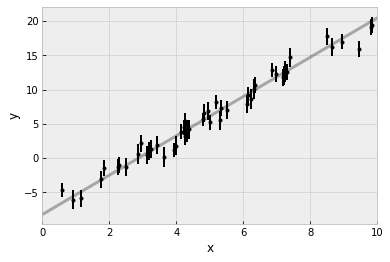

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = 1.8594
b_true = -5.3294
f_true = 1.543

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
y = f_true * (m_true * x + b_true)
yerr = 10.0*(0.1 + 0.05 * np.random.rand(N))
y += np.abs(f_true * y) * np.random.randn(N) * 0.01
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, f_true * (m_true * x0 + b_true), "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


Least-squares estimates:
m = 2.758 ± 0.074
b = -7.616 ± 0.413


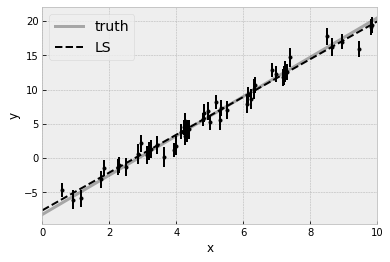

In [3]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, f_true * (m_true * x0 + b_true), "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


In [4]:
def linear_func(m=None, x=x, b=None, f=None):
    return f*(m*x + b)

def model(x):
    b = numpyro.sample('b', dist.Uniform(-2.*abs(b_true*f_true), 2.*abs(b_true*f_true)))
    m = numpyro.sample('m', dist.Uniform(-2.*abs(m_true*f_true), 2.*abs(m_true*f_true)))
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.1, 10.0))
    mu = numpyro.deterministic('mu', linear_func(m=m, x=x, b=b, f=1))
    return numpyro.sample('obs', dist.Normal(mu, sigma), obs=y)
    
#standardize = lambda x: (x - x.mean()) / x.std()
#x_scaled = standardize(x)
#y_scaled = standardize(y)#

#plt.plot(x_scaled, y_scaled, '.')
#plt.plot(x, y, 'x')

In [5]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(12)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=150, num_samples=1200, num_chains=5)


In [6]:
mcmc.run(rng_key_, x=x)
#mcmc.run(rng_key_, x_scaled=x_scaled)
mcmc.print_summary()
samples_1 = mcmc.get_samples()
print(f"b_true = {b_true*f_true}")
print(f"m_true = {m_true*f_true}")

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -7.78      0.37     -7.77     -8.35     -7.15   2654.79      1.00
         m      2.78      0.07      2.78      2.67      2.89   2617.52      1.00
     sigma      1.08      0.11      1.07      0.89      1.26   2194.18      1.00

Number of divergences: 0
b_true = -8.2232642
m_true = 2.8690542


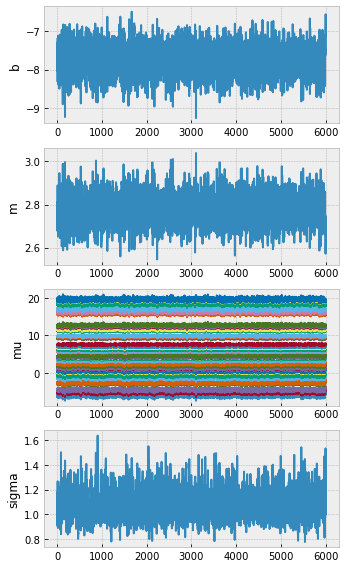

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 8))
axs = axs.flatten()
count = 0
for key in samples_1.keys():
    axs[count].plot(samples_1[f'{key}'])
    axs[count].set_ylabel(f'{key}')
    count += 1
plt.tight_layout()
#plt.plot(samples_1['m'])

In [8]:
samples_1['mu'].shape

(6000, 50)

<AxesSubplot:>

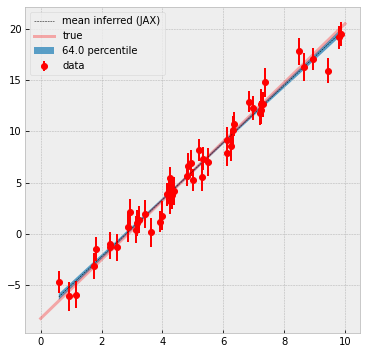

In [9]:
def plot_regression(x, y_mean, y_hpdi, percentile_val):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(x, y_mean, '--k', linewidth=0.5, label='mean inferred (JAX)')
    ax.plot(x0, f_true * (m_true * x0 + b_true), "r", alpha=0.3, lw=3, label='true')
    #ax.plot(x, y, 'o')
    ax.errorbar(x, y, yerr=yerr, fmt='or', label='data')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.8, interpolate=True, label=f'{percentile_val} percentile')
    ax.legend()
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = (jnp.expand_dims(samples_1['m'], -1) * x + 
                jnp.expand_dims(samples_1['b'], -1))
mean_mu = jnp.mean(posterior_mu, axis=0)
percentile_val = 0.64
hpdi_mu = hpdi(posterior_mu, percentile_val)

#plt.plot(x, y, 'x')
#plt.plot(x, mean_mu)
plot_regression(x, mean_mu, hpdi_mu, percentile_val*100)

In [ ]:
numpyro.set_platform('gpu')

In [ ]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(y, mean_mu, hpdi_mu, percentile_val=60)

In [ ]:
?numpyro.plate

In [ ]:
?dist.Uniform

In [ ]:
?dist.Normal